In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Îç∞Ïù¥ÌÑ∞ Í≤ΩÎ°ú ÏßÄÏ†ï
data_dir='C:\\Users\\wader\\workplace_data\\kaggle-kakr-housing-data\\data'
train_data_path= join(data_dir, 'train.csv')
sub_data_path= join(data_dir, 'test.csv')

In [10]:
#Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞(pandasÎ°ú) Î∞è shape ÌôïÏù∏
data=pd.read_csv(train_data_path)
sub=pd.read_csv(sub_data_path)
print('train data dim: {}'.format(data.shape))
print('sub data dim: {}'.format(sub.shape))

train data dim: (15035, 21)
sub data dim: (6468, 20)


In [13]:
y=data['price']

In [ ]:
del data['price']

In [17]:
data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [18]:
train_len=len(data)
data=pd.concat((data, sub), axis=0) #Îç∞Ïù¥ÌÑ∞Í∞Ä axis=0Í∏∞Ï§ÄÏúºÎ°ú(ÏïÑÎûòÎ°ú) Î≥ëÌï©ÌïúÎã§.

print(len(data))

21503


<AxesSubplot:>

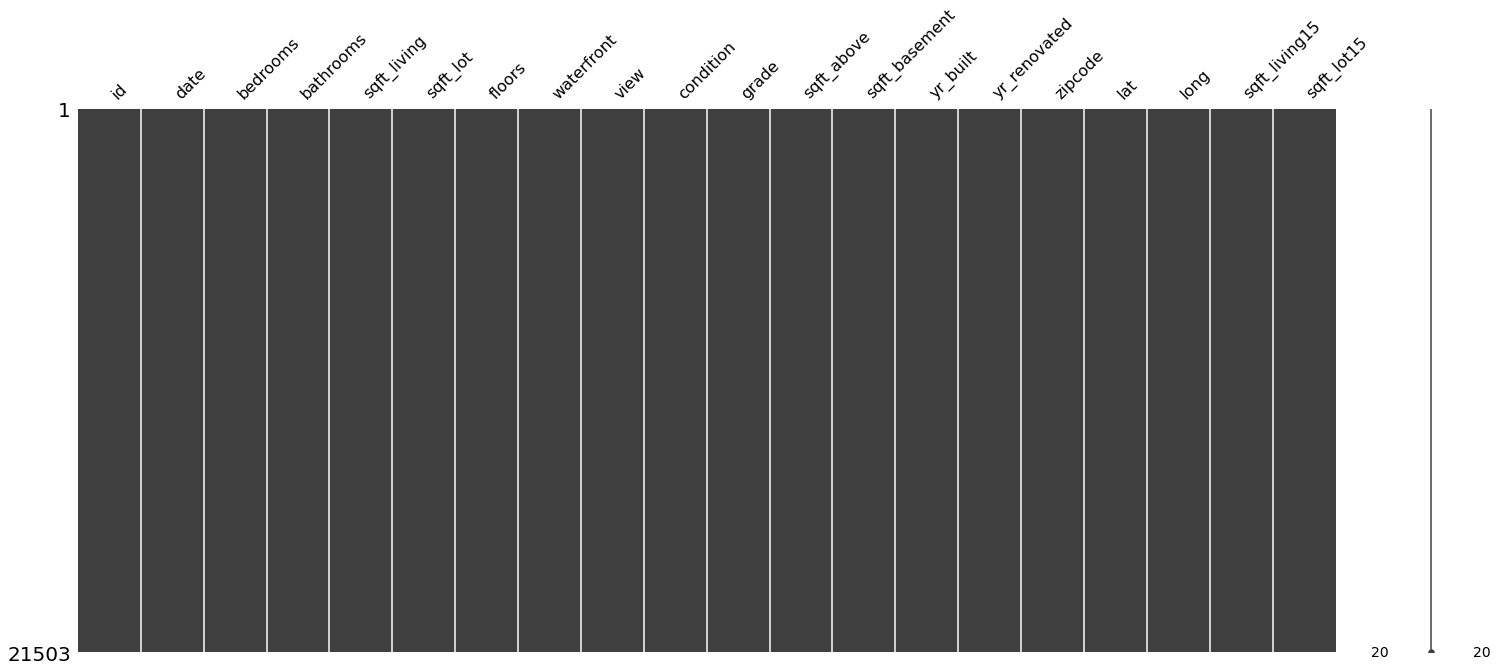

In [19]:
msno.matrix(data) #Î∞î Í∑∏ÎûòÌîÑ ÌòïÌÉúÎ°ú Í≤∞Ï∏°Ïπò ÌôïÏù∏

In [20]:
null_check=pd.isnull(data['id'])# Í≤∞Ï∏°Ïπò ÏûàÎã§Î©¥ indexÍ∏∞Ï§ÄÏúºÎ°ú True Ï∂úÎ†•
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [21]:
null_data=data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [22]:
print(f'id: {len(null_data.values)}')

id: 0


In [23]:
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [25]:
type(data['id'])

pandas.core.series.Series

In [27]:
for c in data.columns:
    print('{}: {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id: 0
date: 0
bedrooms: 0
bathrooms: 0
sqft_living: 0
sqft_lot: 0
floors: 0
waterfront: 0
view: 0
condition: 0
grade: 0
sqft_above: 0
sqft_basement: 0
yr_built: 0
yr_renovated: 0
zipcode: 0
lat: 0
long: 0
sqft_living15: 0
sqft_lot15: 0


In [30]:
sub_id=data['id'][train_len:]
del data['id']
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [31]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410         3       1.00         1180      5650     1.0           0   
1  201502         2       1.00          770     10000     1.0           0   
2  201502         3       2.00         1680      8080     1.0           0   
3  201406         3       2.25         1715      6819     2.0           0   
4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

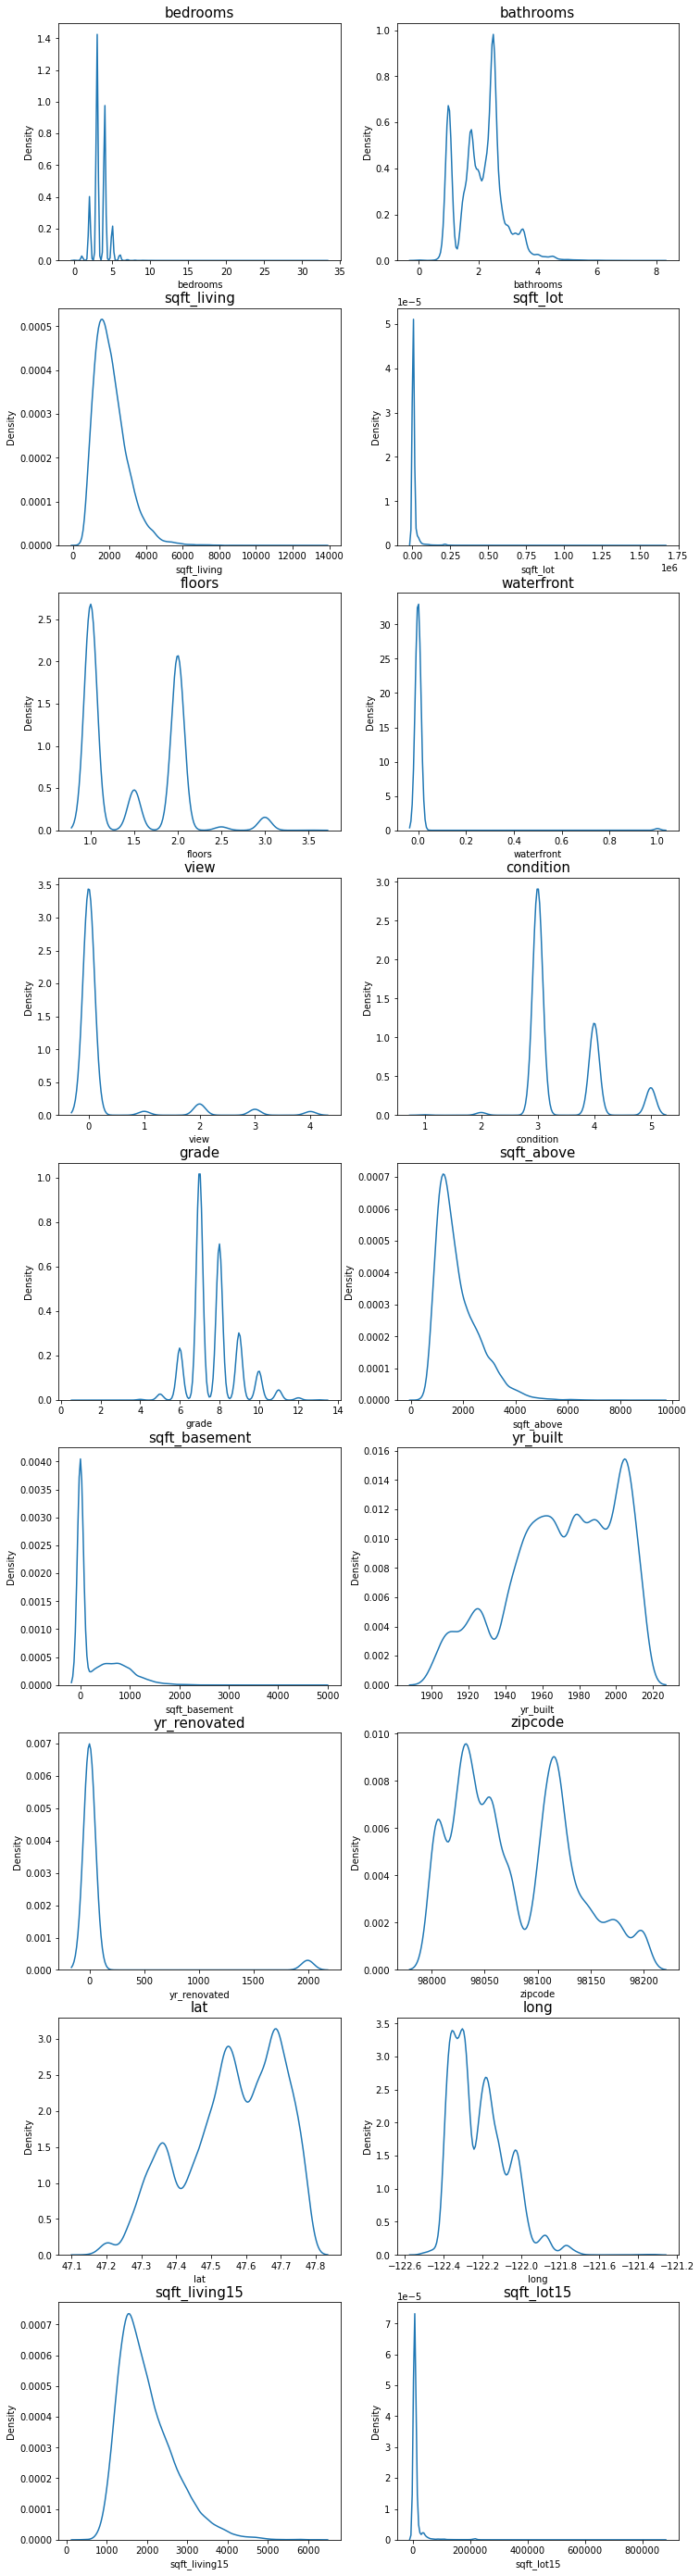

In [32]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # row 9, column 2Ïù∏ Í∑∏ÎûòÌîÑ Í≥µÍ∞ÑÏùÑ ÎßåÎì§Í≥†, Í∞Å Í≥µÍ∞ÑÏùò ÏÇ¨Ïù¥Ï¶àÎäî 12*50ÏúºÎ°ú ÌïúÎã§.

# id Î≥ÄÏàò(count==0Ïù∏ Í≤ΩÏö∞)Îäî Ï†úÏô∏ÌïòÍ≥† Î∂ÑÌè¨Î•º ÌôïÏù∏Ìï©ÎãàÎã§.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [33]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('Ïñçüí¢')

Ïñçüí¢


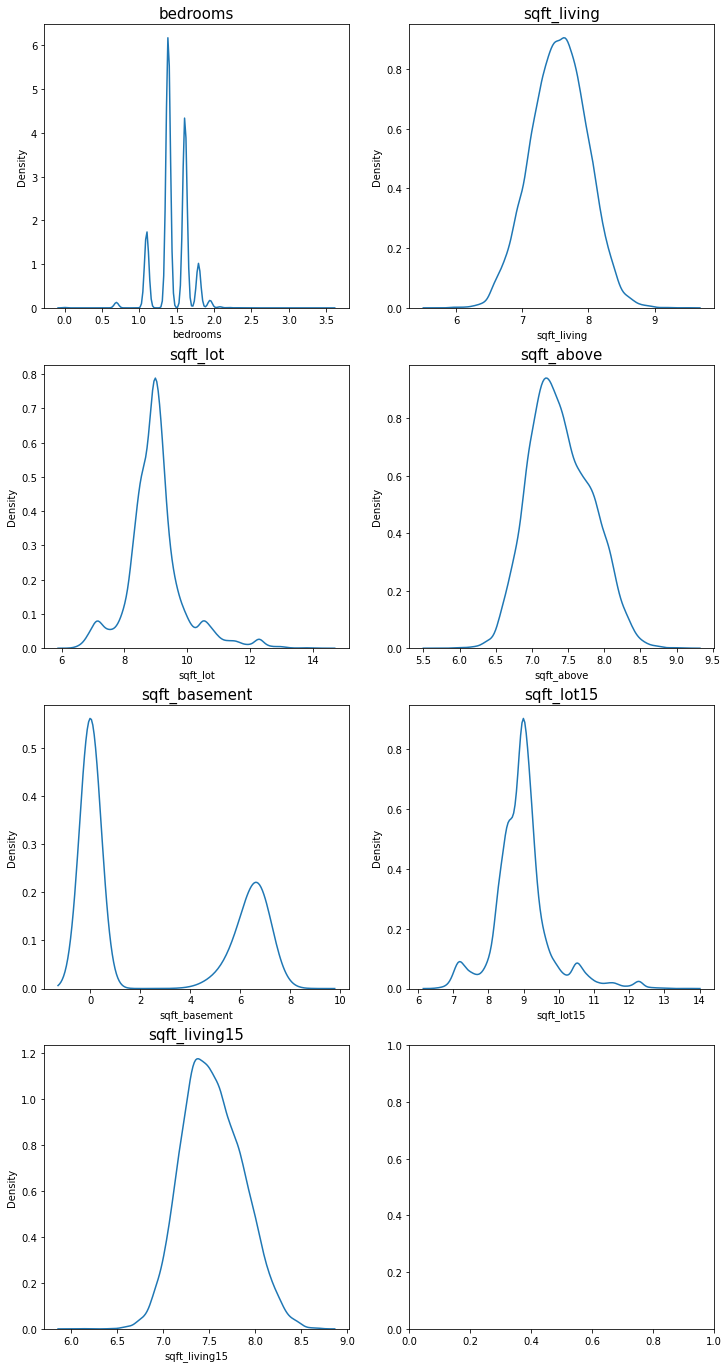

In [34]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

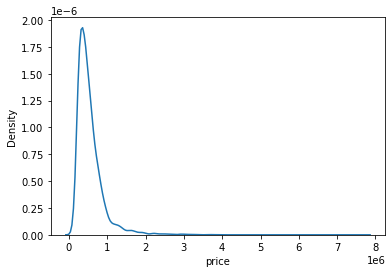

In [35]:
sns.kdeplot(y)
plt.show()

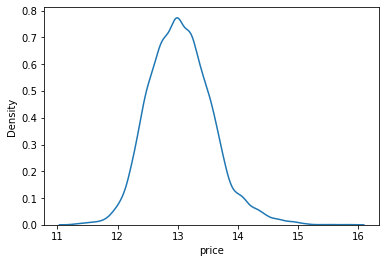

In [36]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [37]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [38]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('Ïñçüí¢')

Ïñçüí¢


In [40]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values) # K fold ÍµêÏ∞®Í≤ÄÏ¶ù.. Ïö∞ÏÑ†ÏùÄ Ìå®Ïä§
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))# ÍµêÏ∞®Í≤ÄÏ¶ùÏö© Ìï®Ïàò
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('Ïñçüí¢')

Ïñçüí¢


In [41]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([ #Î∞∞Ïó¥ Î∂ôÏù¥Í∏∞
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('Ïñçüí¢')

Ïñçüí¢


In [42]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [46]:
data_dir = 'C:\\Users\\wader\\workplace_data\\kaggle-kakr-housing-data\\data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [47]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

id         price
0  15035  5.299667e+05
1  15036  4.307262e+05
2  15037  1.361677e+06
3  15038  3.338036e+05
4  15039  3.089006e+05

In [48]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

C:\Users\wader\workplace_data\kaggle-kakr-housing-data\data\submission.csv
